# 경영자를 위한 딥러닝 개인 과제

2021년 6월 19일

Kaggle Exercise / IMMS / 은송희 / 20194252


**Topic : CommonLit Readability Prize**

텍스트 구절의 적절한 읽기 수준을 식별하고 학습에 영감을 주기 위한 프로젝트

**목표** : 3-12학년 교실 사용에 대한 읽기 구절의 복잡성을 평가하는 알고리즘을 구축

**배경** : 상업적으로 이용 가능한 도구(예:Lexile 등)는  비용이 많이 들수 있고 적절한 유효성 검사 연구가 부족하며 수식의 기능을 공개적으로 사용할 수 없을 때 투명성 문제가 생김.
CommonLit, Inc. (3-12 학년을 위한 무료 디지털 읽기 및 쓰기 수업을 제공하는 비영리 조직) 과 R1 공공 연구 대학인 조지아 주립 대학이 가독성 등급 방법을 개선하기 위해 Kagglers과제로 도전.

**평가지표**: RMSE (Root Mean Square Error) 

**데이터**

**Files**
•	train.csv - the training set

•	test.csv - the test set

•	sample_submission.csv - a sample submission file in the correct format

**Columns**
•	id - unique ID for excerpt

•	url_legal - URL of source - this is blank in the test set.

•	license - license of source material - this is blank in the test set.

•	excerpt - text to predict reading ease of

•	target - reading ease

•	standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.


## Setup

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import numpy as np
from keras import backend as K

import re
import nltk
from nltk.corpus import stopwords

In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Implement a Transformer block as a layer

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer
#### Two seperate embedding layers, one for tokens, one for token index (positions).

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Prepare dataset

In [5]:
#train = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
#test = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
train = pd.read_csv('/content/gdrive/MyDrive/DeepL/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/DeepL/test.csv')

In [8]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


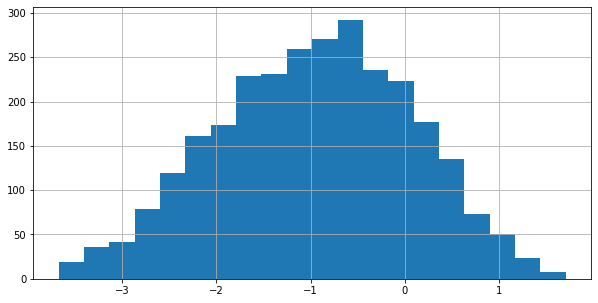

In [9]:
hist = train.target.hist(figsize=(10, 5), bins=20)

## Data preprocessing

In [10]:
 nltk.download('stopwords')
 nltk.download('punkt')
 nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
#====== Preprocessing function ======
stop_words =  set(stopwords.words("english"))
lemma = nltk.WordNetLemmatizer()

def preprocess(e):
    # find alphabets
    e = re.sub("[^a-zA-Z]", " ", e)
    # convert to lower case
    e = e.lower()
    # tokenize words
    e = nltk.word_tokenize(e)
    # remove stopwords
    e = [word for word in e if not word in stop_words]
    # lemmatization
    e = [lemma.lemmatize(word) for word in e]
    e=" ".join(e)
    return e

train.excerpt = train.excerpt.apply(preprocess)
test.excerpt = test.excerpt.apply(preprocess)

In [12]:
text = pd.concat([train.excerpt, test.excerpt], axis=0)

## text to sequences

In [13]:
vocab_size=18000
t = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)

train_text = train.excerpt.values
test_text = test.excerpt.values

t.fit_on_texts(train_text)

train_sequences = t.texts_to_sequences(train_text)
test_sequences = t.texts_to_sequences(test_text)

### Pad sequences

In [14]:
maxlen=200

X_train = keras.preprocessing.sequence.pad_sequences(train_sequences, 
                                                     maxlen=maxlen,
                                                     padding='post')

X_test = keras.preprocessing.sequence.pad_sequences(test_sequences,
                                                    maxlen=maxlen,
                                                    padding='post')

## Create model using transformer layer

In [19]:
def get_model():
    embed_dim = 32  # Embedding size for each token
    num_heads = 3  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='linear')(x)      #softmax 사용시 loss 와 rmse 가 줄지 않고 변동이 없음 

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = [tf.keras.losses.MeanSquaredError()],
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [20]:
# Early stopping

early_stop = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           mode='min',
                                           verbose=1,
                                           patience=10)

## F fold cross validation

In [21]:
folds = KFold(n_splits=5)

test_preds = np.zeros(len(X_test))
y_train = train['target'].values

for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print(f'\n------------- Fold {i + 1} -------------')
    ############# Get train, validation and test sets along with targets ################
    
    ### Training Set
    X_trn, y_trn = X_train[trn_idx], y_train[trn_idx]
    ### Validation Set
    X_val, y_val = X_train[val_idx], y_train[val_idx]
    
    ########## Get model ############
    model = get_model()

    ############# Fitting and Predicting ################
    history = model.fit(X_trn, y_trn,
                    batch_size=32,
                    epochs=15, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

    ### prediction
    test_preds += model.predict(X_test)[:,0]/5
    
    K.clear_session()
    print()


------------- Fold 1 -------------
Epoch 1/15
71/71 [==============================] - 12s 155ms/step - loss: 1.0687 - root_mean_squared_error: 1.0338 - val_loss: 0.6070 - val_root_mean_squared_error: 0.7791
Epoch 2/15
71/71 [==============================] - 11s 150ms/step - loss: 0.5892 - root_mean_squared_error: 0.7676 - val_loss: 0.5555 - val_root_mean_squared_error: 0.7453
Epoch 3/15
71/71 [==============================] - 11s 152ms/step - loss: 0.3181 - root_mean_squared_error: 0.5640 - val_loss: 0.6265 - val_root_mean_squared_error: 0.7915
Epoch 4/15
71/71 [==============================] - 11s 152ms/step - loss: 0.2197 - root_mean_squared_error: 0.4688 - val_loss: 0.5911 - val_root_mean_squared_error: 0.7688
Epoch 5/15
71/71 [==============================] - 11s 153ms/step - loss: 0.1586 - root_mean_squared_error: 0.3983 - val_loss: 0.6147 - val_root_mean_squared_error: 0.7841
Epoch 6/15
71/71 [==============================] - 11s 150ms/step - loss: 0.1202 - root_mean_squar

## Submission

In [22]:
sub = pd.read_csv("/content/gdrive/MyDrive/DeepL/sample_submission.csv")
sub["target"]=test_preds
sub.to_csv("/content/gdrive/MyDrive/DeepL/submission.csv",index=False)

### Reference
#### https://keras.io/examples/nlp/text_classification_with_transformer/

https://www.tensorflow.org/guide/function?hl=ko